In [1]:
import numpy as np
import time
import math
import kornia

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
# Set Important Values

data = '/data/dww78/mini_inat_shrunk/'
gpu = 2
torch.cuda.set_device(gpu)
workers = 4
epoch = 10
start_epoch = 0
vbity = 20
esize = 4
augmentation_flipping = True        
include_masks = False

bsize = 128

In [3]:
# The cell below is almost certainly wrong - use the newer load_transform function and load from existing datasets 
# ('repr' and 'query' I think)

In [4]:
# Load Training/Testing Data

d_boxes = torch.load('/data/db638/github/fewshotlocal/helpful_files/box_coords.pth')


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, boxdict, transform, flipping, masking):
    # Load the image
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    # Load the bounding boxes
    m = t
    if masking:
        allmasks = np.zeros((10,10))
        boxes = boxdict[path]
        for box in boxes:
            mask = np.zeros((10,10))
            xmin = box[0]
            xmax = box[2]-.0000001 # Prevents overflow when xmax is exactly 10
            ymin = box[1]
            ymax = box[3]-.0000001
            xmin_int = int(xmin)
            xmax_int = int(xmax)+1
            ymin_int = int(ymin)
            ymax_int = int(ymax)+1
            if not flip or not flipping:
                mask[ymin_int:ymax_int, xmin_int:xmax_int] = 1
                # Fade out the left and right edges of the mask
                mask[:, xmin_int] *= 1 - (xmin - xmin_int)
                mask[:, xmax_int-1] *= 1 - (xmax_int - xmax)
            else:
                mask[ymin_int:ymax_int, 10-xmax_int:10-xmin_int] = 1
                # Fade out the left and right edges of the mask
                mask[:, 10-xmin_int-1] *= 1 - (xmin - xmin_int)
                mask[:, 10-xmax_int] *= 1 - (xmax_int - xmax)
            # Fade out the top and bottom edges of the mask
            mask[ymin_int,:] *= 1 - (ymin - ymin_int)
            mask[ymax_int-1,:] *= 1 - (ymax_int - ymax)
            # Take the union of the previous and current masks
            allmasks = 1 - (1-allmasks)*(1-mask) 
        m = torch.FloatTensor(allmasks).unsqueeze(0)
    return [t, m]


train_dataset = datasets.ImageFolder(
    data+'repr', 
    loader = lambda x: load_transform(x, d_boxes, transform, augmentation_flipping, include_masks))
test_dataset = datasets.ImageFolder(
    data+'query',
    loader = lambda x: load_transform(x, d_boxes, transform, augmentation_flipping, include_masks))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size = bsize,
    shuffle = True,
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = bsize,
    shuffle = True,
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
227 227


In [5]:
# You should probably replace all the .cuda(device = gpu, async=True) with plain .cuda()

In [6]:
# Define the Procedures

def train(train_loader, epoch, gpu, vbity):
    for model in smodel:
        model.train()
    allloss = [0]*esize
#     for i, (inp, targ) in enumerate(train_loader):
    for i, ((inp, inp2), target) in enumerate(train_loader):
        inp = Variable(inp).cuda()
        targ = Variable(target).cuda()
        for j in range(esize):
            smodel[j].zero_grad()
            out = smodel[j](inp)
            loss = criterion(out, targ)
            loss.backward()
            soptimizer[j].step()
        
            allloss[j] += loss.item()
            
        if i%vbity == 0:
            print('%d of approx. 9000'%(i*bsize))
    return [L/i for L in allloss]

def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
#         for i, (inp, targ) in enumerate(val_loader):
        for i, ((inp, inp2), target) in enumerate(val_loader):
            inp = Variable(inp).cuda()
            targ = Variable(target).cuda()

            with torch.no_grad():
                for j in range(esize):
                    out = smodel[j](inp)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/bsize
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 36000'%(r+1, reps, i*bsize))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

print('Ready to go!')

Ready to go!


In [16]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from kornia.utils.one_hot import one_hot


# based on:
# https://github.com/zhezh/focalloss/blob/master/focalloss.py

def focal_loss(
        input: torch.Tensor,
        target: torch.Tensor,
        alpha: float,
        gamma: float = 2.0,
        reduction: str = 'none',
        eps: float = 1e-8) -> torch.Tensor:
    r"""Function that computes Focal loss.

    See :class:`~kornia.losses.FocalLoss` for details.
    """
    if not torch.is_tensor(input):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) >= 2:
        raise ValueError("Invalid input shape, we expect BxCx*. Got: {}"
                         .format(input.shape))

    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError('Expected target size {}, got {}'.format(
            out_size, target.size()))

    if not input.device == target.device:
        raise ValueError(
            "input and target must be in the same device. Got: {} and {}" .format(
                input.device, target.device))

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1) + eps

    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(
        target, num_classes=input.shape[1],
        device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1., gamma)

    focal = -alpha * weight * torch.log(input_soft)
#     *****INPUT THE WEIGHTS HERE/TENSOR BROADCASTING*****
    beta = 0.5
    samples_per_cls = torch.Tensor(np.array([t[1] for t in train_dataset.imgs])).int().bincount().float()
    no_of_classes = 227
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    loss_tmp = torch.sum(target_one_hot * torch.from_numpy(weights).cuda() * focal, dim=1)
    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError("Invalid reduction mode: {}"
                                  .format(reduction))
    return loss



class FocalLoss(nn.Module):
    r"""Criterion that computes Focal loss.

    According to [1], the Focal loss is computed as follows:

    .. math::

        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)

    where:
       - :math:`p_t` is the model's estimated probability for each class.


    Arguments:
        alpha (float): Weighting factor :math:`\alpha \in [0, 1]`.
        gamma (float): Focusing parameter :math:`\gamma >= 0`.
        reduction (str, optional): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.

    Shape:
        - Input: :math:`(N, C, *)` where C = number of classes.
        - Target: :math:`(N, *)` where each value is
          :math:`0 ≤ targets[i] ≤ C−1`.

    Examples:
        >>> N = 5  # num_classes
        >>> kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'}
        >>> loss = kornia.losses.FocalLoss(**kwargs)
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = loss(input, target)
        >>> output.backward()

    References:
        [1] https://arxiv.org/abs/1708.02002
    """

    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(FocalLoss, self).__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: float = 1e-6

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

In [17]:
# Make Models

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class SIGGER(nn.Module):
    def __init__(self, n_classes):
        super(SIGGER, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(10)
        )
        self.postprocess = nn.Sequential(
            nn.Linear(64, n_classes),
            nn.LogSoftmax(dim=-1))
        
    def forward(self, inp):
        return self.postprocess(self.process(inp).view(inp.size(0),64))
    
smodel = [SIGGER(227).cuda() for i in range(esize)]
soptimizer = [optim.Adam(m.parameters(), lr=.001) for m in smodel]
sscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in soptimizer]


kwargs = {"alpha": 1.0, "gamma": 2.0, "reduction": 'mean'}
loss = FocalLoss(**kwargs)
criterion = loss

# criterion = nn.NLLLoss().cuda()#                                                        <-- replace this with focal loss
cudnn.benchmark = True

nweights = sum([i.numel() for i in list(smodel[0].parameters())])
print(nweights," parameters in each neural net.")

127843  parameters in each neural net.


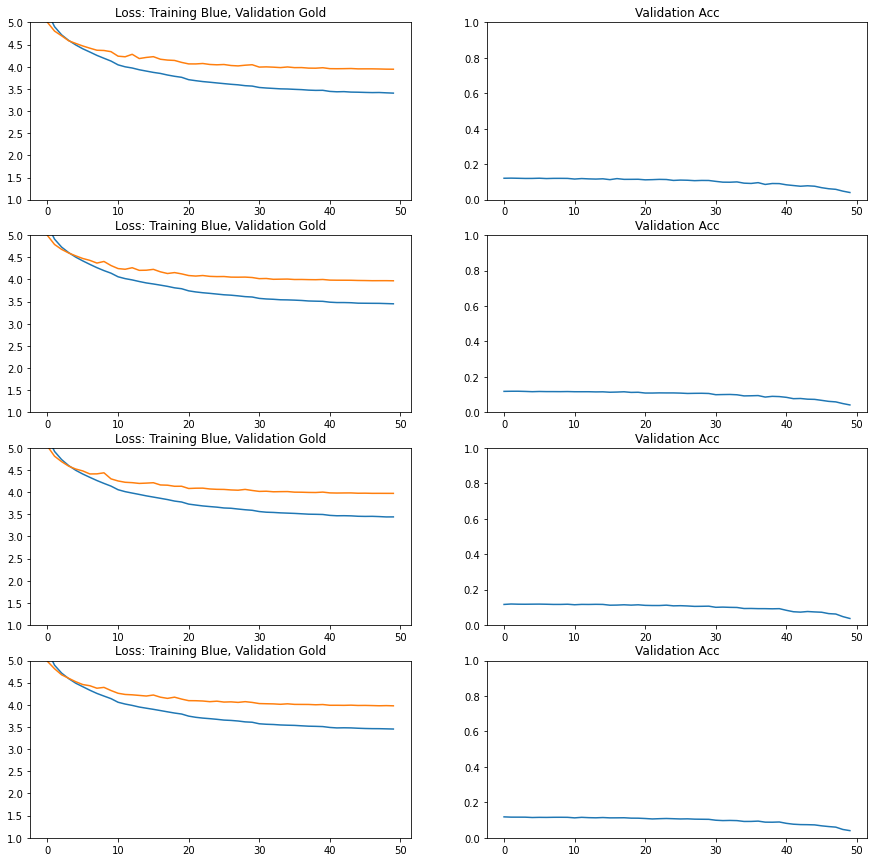

Train loss is: [3.4040883426934903, 3.450139277417895, 3.4414477549808127, 3.4544410000384693]
Validation accuracy is: [0.1208118556701031, 0.11852985395189003, 0.11651632302405499, 0.11807345360824742]
Validation loss is: [3.9435339311073565, 3.9696138307966033, 3.9723883933034436, 3.978309394573343]

0.01 hours to completion

0.5192379213704004 hours total
Model 0 final score: 12.13 +- 0.10
Model 1 final score: 11.82 +- 0.10
Model 2 final score: 11.73 +- 0.10
Model 3 final score: 11.70 +- 0.10


In [18]:
# Do the Thing!

start = time.time()
trainlosses, testlosses, acctracker = [[] for _ in range(esize)],[[] for _ in range(esize)],[[] for _ in range(esize)]
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in sscheduler]
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, _ = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    for j in range(esize):
        trainlosses[j].append(trainloss[j])
        testlosses[j].append(testloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(esize):
        pl.subplot(esize,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.plot(testlosses[i])
        pl.ylim((1,5))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(esize,2,2*i+2)
        pl.plot(acctracker[i][::-1])
        pl.ylim((0,1))
        pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600, "hours total") 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

In [19]:
torch.save([m.cpu().state_dict() for m in smodel], 'focal_loss_CB.pth')

In [20]:
#                                                    EVALUATE

In [21]:
# Originally, I wrote this so that you could run it on its own without running any cells above. 
# This does mean that any changes you make up there you'll have to repeat down here
# (or just rewrite the code to use the dataloaders/models/etc. from above)

In [22]:
pathto = 'focal_loss_CB.pth'

# import numpy as np
# import time
# import math

# # time.sleep(2*3600)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.autograd as autograd
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torch.backends.cudnn as cudnn
# from torch.autograd import Variable
# from torch.nn.parameter import Parameter

# %matplotlib inline
# import pylab as pl

# from IPython import display
# from copy import deepcopy
# from skimage.transform import resize
# from PIL import Image

# Set Important Values

# data = '/data/dww78/mini_inat_shrunk/'
# gpu = 0
# torch.cuda.set_device(gpu)
# workers = 4
# vbity = 20
# esize = 4
# threshold = .15

# bsize = 100

# Load Training/Testing Data

# d_boxes = torch.load('/data/db638/github/fewshotlocal/helpful_files/box_coords.pth')

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
#     ])



# class ProtoSampler(torch.utils.data.sampler.Sampler):
#     def __init__(self, data_source):
#         iddict = dict()
#         for i,(_,cat) in enumerate(data_source.imgs):
#             if cat in iddict:
#                 iddict[cat].append(i)
#             else:
#                 iddict[cat] = [i]
#         self.iddict = iddict
        
#     def __iter__(self):
#         trackdict = deepcopy(self.iddict)
#         for key in trackdict:
#             np.random.shuffle(trackdict[key])
#         for key in trackdict:
#             idlist = trackdict[key]
#             size = len(idlist)
#             if size <= bsize:
#                 yield idlist
#             else:
#                 for i in range(len(idlist)//bsize):
#                     yield idlist[i*bsize:(i+1)*bsize]
#                 if size%bsize != 0:
#                     yield idlist[-(len(idlist)%bsize):]


# Create models

# class Block(nn.Module):
#     def __init__(self, insize, outsize):
#         super(Block, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
#             nn.BatchNorm2d(outsize)
#         )
        
#     def forward(self, inp):
#         return self.layers(inp)

# class SIGGER(nn.Module):
#     def __init__(self, n_classes):
#         super(SIGGER, self).__init__()
#         self.process = nn.Sequential(
#             Block(3,64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             Block(64,64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             Block(64,64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             Block(64,64),
#             nn.ReLU(inplace=True),
#             nn.AvgPool2d(10)
#         )
#         self.postprocess = nn.Sequential(
#             nn.Linear(64, n_classes),
#             nn.LogSoftmax(dim=-1))
        
#     def forward(self, inp):
#         return self.postprocess(self.process(inp).view(inp.size(0),64))
    
smodel = [SIGGER(227).cuda() for i in range(esize)]
s = torch.load(pathto)
for j in range(esize):
    smodel[j].load_state_dict(s[j]) 
    smodel[j].eval() 

print("Models built!")

# Total accuracy, class accuracy

def score(k):
    way = 227
    right = [0]*esize
    allright = [0]*esize
    perclassacc = np.array([[0.]*way for _ in range(esize)])
    catindex = 0
    lastcat = -1
    count = 0
    allcount = 0
#     for i, (inp, cat) in enumerate(test_loader):
#         print("INP")
#         print(inp)
#         print("CAT")
#         print(cat)
    for i, ((inp, inp2), target) in enumerate(test_loader):
        catindex = target[0]
        if catindex != lastcat: # We're about to move to another category
            if catindex%10==0:
                print(catindex.item())
            # Write the values
            if i!= 0:
                allcount += count
                for j in range(esize):
                    allright[j] += right[j] 
                    perclassacc[j, lastcat] = right[j]/count
            lastcat = catindex # Record the current category
            count = 0 # Reset divisor
            right = [0]*esize # Reset accumulator

        # Predict
        inp = Variable(inp).cuda()
        targ = Variable(target).cuda()
        with torch.no_grad():
            for j in range(esize):
                out = smodel[j](inp)
                _, pred = out.topk(k, 1, True, True)
                pred = pred.t()
                right[j] += pred.eq(targ.view(1, -1).expand_as(pred))[:k].view(-1).float().sum(0, keepdim=True).float().item()
        count += inp.size(0)

    # Record last category
    allright[j] += right[j]
    allcount += count
    perclassacc[j, catindex] = right[j]/count

    # Final reporting / recording
    allacc = [r/allcount for r in allright]
    
    return allacc, np.mean(perclassacc, axis=1)

Models built!


In [23]:
# top-1 accuracy, avg and per-class (with 95% confidence intervals)

In [24]:
reps = 1
ngiven = [1]
accs = [0 for _ in ngiven]
confs = [0 for _ in ngiven]
pcaccs = [0 for _ in ngiven]
pcconfs = [0 for _ in ngiven]

timeto = 0
start = time.time()
for g, given in enumerate(ngiven):
    acclist = []
    pcacclist = []
    for r in range(reps):
        allacc, perclassacc = score(1)
        acclist = acclist+allacc
        pcacclist = pcacclist+list(perclassacc)
        display.clear_output(wait=True)
        
    accs[g] = sum(acclist)/reps/esize
    pcaccs[g] = sum(pcacclist)/reps/esize
    confs[g] = 1.96*np.sqrt(np.var(acclist)/reps/esize)
    pcconfs[g] = 1.96*np.sqrt(np.var(pcacclist)/reps/esize)

for i in range(len(ngiven)):
    print(accs[i]*100, confs[i]*100)
print()
for i in range(len(ngiven)):
    print(pcaccs[i]*100, pcconfs[i]*100)

11.808562131927824 0.11939780717427313

6.905951554178447 0.0823680509368837


In [25]:
# top-5 accuracy, avg and per-class (with 95% confidence intervals)

In [26]:
reps = 1
ngiven = [1]
accs = [0 for _ in ngiven]
confs = [0 for _ in ngiven]
pcaccs = [0 for _ in ngiven]
pcconfs = [0 for _ in ngiven]

timeto = 0
start = time.time()
for g, given in enumerate(ngiven):
    acclist = []
    pcacclist = []
    for r in range(reps):
        allacc, perclassacc = score(5)
        acclist = acclist+allacc
        pcacclist = pcacclist+list(perclassacc)
        display.clear_output(wait=True)
        
    accs[g] = sum(acclist)/reps/esize
    pcaccs[g] = sum(pcacclist)/reps/esize
    confs[g] = 1.96*np.sqrt(np.var(acclist)/reps/esize)
    pcconfs[g] = 1.96*np.sqrt(np.var(pcacclist)/reps/esize)

for i in range(len(ngiven)):
    print(accs[i]*100, confs[i]*100)
print()
for i in range(len(ngiven)):
    print(pcaccs[i]*100, pcconfs[i]*100)

31.873369725979504 0.2756117238273777

20.15307419743244 0.19379919791900113


In [ ]:
%%javascript
Jupyter.notebook.session.delete();